#### DATA PREPROCESSING

In [1]:
import pandas as pd
df = pd.read_csv('titleYoutube.csv')

In [2]:
df = df.drop(['videoDescription', 'videoCategoryLabel','Unnamed: 0','position','channelId','videoId','publishedAt','publishedAtSQL','videoCategoryId',
                         'duration','durationSec', 'dimension', 'definition', 'caption', 'licensedContent', 'video_link', 'datePublished',
                         'timePublished', 'datePublishedSQL', 'timePublishedSQL','__index_level_0__','favoriteCount'], axis=1)

In [3]:
df.head()

,channelTitle,videoTitle,viewCount,likeCount,dislikeCount,commentCount,thumbnail
0,Najwa Shihab,Di Balik Layar Hiduplah Hari Ini - Dialog Dini...,28751.0,903.0,23.0,71.0,http://img.youtube.com/vi/ZmlZpOLRMhE/0.jpg
1,metrotvnews,Interview with SISITIPSI,11647.0,96.0,2.0,5.0,http://img.youtube.com/vi/S2DliNcO7LA/0.jpg
2,metrotvnews,SISITIPSI - Joni Santai [Live Performance],13958.0,80.0,5.0,2.0,http://img.youtube.com/vi/Li3CZ7t03TA/0.jpg
3,metrotvnews,Realitas - Langkah Banding Kartel Motor,872.0,7.0,0.0,5.0,http://img.youtube.com/vi/OojiP1ph-eQ/0.jpg
4,metrotvnews,Target Operasi - Calo TKI Ilegal Timur Tengah,100847.0,316.0,39.0,315.0,http://img.youtube.com/vi/3Kx9YMT_ZIE/0.jpg


In [13]:
df_narasi = df[df['channelTitle'].isin(['Najwa Shihab', 'Narasi Channel', 'Nara-Z'])]
print(df_narasi.head(3))

      channelTitle                                         videoTitle  \
0     Najwa Shihab  Di Balik Layar Hiduplah Hari Ini - Dialog Dini...   
6549  Najwa Shihab  Panggung Srimulat (Part 7): Dari Reuni ke Laya...   
6550  Najwa Shihab  Panggung Srimulat (Part 6): Sumber Inspirasi G...   

      viewCount  likeCount  dislikeCount  commentCount  \
0       28751.0      903.0          23.0          71.0   
6549   145155.0     1928.0          21.0         216.0   
6550   197433.0     1771.0          43.0         105.0   

                                        thumbnail  
0     http://img.youtube.com/vi/ZmlZpOLRMhE/0.jpg  
6549  http://img.youtube.com/vi/ii-E6OwxzQA/0.jpg  
6550  http://img.youtube.com/vi/xH5yuVcidW0/0.jpg  


In [32]:
thumbnails = df_narasi.thumbnail.values.tolist()

In [34]:
thumbnails[0:3]

['http://img.youtube.com/vi/ZmlZpOLRMhE/0.jpg',
 'http://img.youtube.com/vi/ii-E6OwxzQA/0.jpg',
 'http://img.youtube.com/vi/xH5yuVcidW0/0.jpg']

In [17]:
import cv2
import math
import os.path
import numpy as np

In [18]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt
%matplotlib inline

import skimage.io
import skimage.transform

In [19]:
import os
os.chdir('/Users/anggapradiktas/Documents/libsvm/python')
import svm
import svmutil

In [20]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

In [21]:
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

In [22]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

In [23]:
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [24]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

In [25]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [26]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

In [27]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

In [28]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

In [35]:
data = []
for u in thumbnails:
    image = load_image(u)
    data.append(image)

In [36]:
gray_image = []
for d in data:
    convert_to_gray = skimage.color.rgb2gray(d)
    gray_image.append(convert_to_gray)

In [37]:
mscn_coefficients = []
for g in gray_image:
    mscn_holder = calculate_mscn_coefficients(g, 7, 7/6)
    mscn_coefficients.append(mscn_holder)

In [42]:
coefficients = []
for m in mscn_coefficients:
    coef_holder = calculate_pair_product_coefficients(m)
    coefficients.append(coef_holder)

In [46]:
brisque_features = []
for g in gray_image:
    brisque_holder = calculate_brisque_features(g, kernel_size=7, sigma=7/6)
    brisque_features.append(brisque_holder)

In [47]:
downscaled_image = []
for g in gray_image:
    down_holder = cv2.resize(g, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    downscaled_image.append(down_holder)

In [48]:
downscale_brisque_features = []
for down in downscaled_image:
    features_holder = calculate_brisque_features(down, kernel_size=7, sigma=7/6)
    downscale_brisque_features.append(features_holder)

In [49]:
brisque_features_1 = []
for bf, dbf in zip(brisque_features, downscale_brisque_features):
    brisque_features_holder = np.concatenate((bf, dbf))
    brisque_features_1.append(brisque_features_holder)

In [50]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)
    
    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

In [51]:
score = []

for bf1 in brisque_features_1:
    score_holder = calculate_image_quality_score(bf1)
    score.append(score_holder)

In [56]:
df_score = pd.DataFrame({'score':score})

,score
0,54.985461
1,55.344489
2,37.360060
3,58.231826
4,55.575654


In [66]:
df_narasi = df_narasi.reset_index(drop=True)

In [111]:
df_combine = pd.concat([df_narasi, df_score], axis=1)

In [98]:
#df_combine.to_csv('df_score_views.csv')

In [99]:
pwd

'/Users/anggapradiktas/Documents/libsvm/python'

In [70]:
df_combine.head()

,channelTitle,videoTitle,viewCount,likeCount,dislikeCount,commentCount,thumbnail,score
0,Najwa Shihab,Di Balik Layar Hiduplah Hari Ini - Dialog Dini...,28751.0,903.0,23.0,71.0,http://img.youtube.com/vi/ZmlZpOLRMhE/0.jpg,54.985461
1,Najwa Shihab,Panggung Srimulat (Part 7): Dari Reuni ke Laya...,145155.0,1928.0,21.0,216.0,http://img.youtube.com/vi/ii-E6OwxzQA/0.jpg,55.344489
2,Najwa Shihab,Panggung Srimulat (Part 6): Sumber Inspirasi G...,197433.0,1771.0,43.0,105.0,http://img.youtube.com/vi/xH5yuVcidW0/0.jpg,37.360060
3,Najwa Shihab,Panggung Srimulat (Part 5): Srimulatisme; Genr...,156493.0,1491.0,36.0,112.0,http://img.youtube.com/vi/Xe4hBnAwmDI/0.jpg,58.231826
4,Najwa Shihab,"Panggung Srimulat (Part 4): Srimulat, Gudangny...",182744.0,1645.0,43.0,132.0,http://img.youtube.com/vi/i8u0yxb2GZs/0.jpg,55.575654


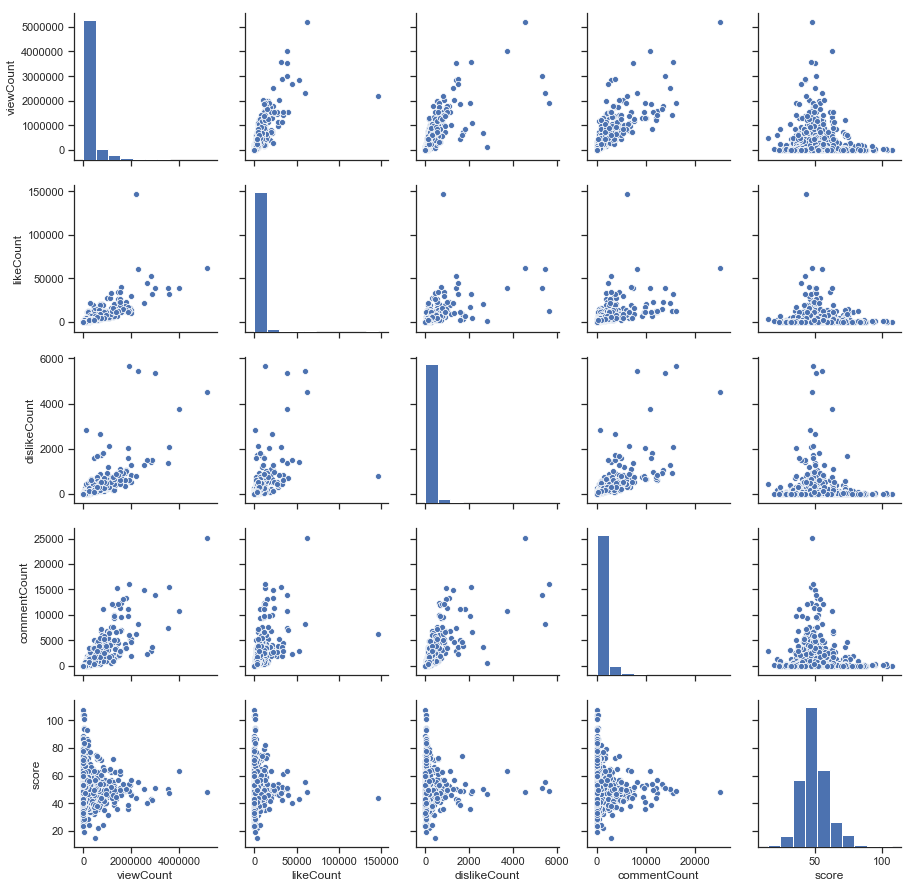

In [74]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_combine)

In [79]:
df_combine.sort_values('score').head()

,channelTitle,videoTitle,viewCount,likeCount,dislikeCount,commentCount,thumbnail,score
818,Najwa Shihab,Mata Najwa Part 1 - Bara Jelang 2019: Kesaksia...,499611.0,3510.0,420.0,2821.0,http://img.youtube.com/vi/FA450ud17SU/0.jpg,15.073791
1140,Najwa Shihab,"Munir, Keadilan yang Belum Tuntas",33665.0,1054.0,8.0,93.0,http://img.youtube.com/vi/esztNGHZSpM/0.jpg,19.415472
1043,Najwa Shihab,Part 5 - Kartu Kuning Jokowi: Kecemasan Kembal...,617130.0,2678.0,173.0,1265.0,http://img.youtube.com/vi/gr7stqYBNkg/0.jpg,21.750977
290,Narasi Channel,Pemburu Peristiwa | Narasi People,12410.0,104.0,5.0,5.0,http://img.youtube.com/vi/AoezmZA_WMI/0.jpg,22.777777
1372,Najwa Shihab,TAN MALAKA: Kisah Bapak Republik,6325.0,95.0,0.0,1.0,http://img.youtube.com/vi/hlloo2QDQvg/0.jpg,23.367693


In [97]:
df_combine.loc[(df_combine['score'] >= 50) & (df_combine['viewCount'] >= 500000)].sort_values('viewCount', ascending=False).head(3)

,channelTitle,videoTitle,viewCount,likeCount,dislikeCount,commentCount,thumbnail,score
1236,Najwa Shihab,Suara Penentu: Beda Jokowi dan Prabowo Sikapi ...,4020676.0,38993.0,3740.0,10719.0,http://img.youtube.com/vi/aS5sX-MywbA/0.jpg,62.925466
450,Najwa Shihab,PSSI Bisa Apa: Buka-Bukaan Pengaturan Skor Bol...,3528503.0,38665.0,1375.0,7452.0,http://img.youtube.com/vi/tRu8FhUnlDY/0.jpg,50.034018
1349,Najwa Shihab,Berburu Suara Penentu: Yusuf Mansur Soal Keisl...,3013454.0,39226.0,5342.0,13915.0,http://img.youtube.com/vi/21gSbginMU0/0.jpg,50.879350


In [117]:
pd.set_option('precision', 0)

In [118]:
df_combine.head(2)

,channelTitle,videoTitle,viewCount,likeCount,dislikeCount,commentCount,thumbnail,score
0,Najwa Shihab,Di Balik Layar Hiduplah Hari Ini - Dialog Dini...,28751,903,23,71,http://img.youtube.com/vi/ZmlZpOLRMhE/0.jpg,55
1,Najwa Shihab,Panggung Srimulat (Part 7): Dari Reuni ke Laya...,145155,1928,21,216,http://img.youtube.com/vi/ii-E6OwxzQA/0.jpg,55


In [119]:
from sklearn import svm
clf = svm.SVC(gamma='scale')

In [139]:
X = df_combine['score'].round().values.reshape(-1,1)
y = df_combine['viewCount'].values

In [140]:
X

array([[55.],
       [55.],
       [37.],
       ...,
       [60.],
       [56.],
       [50.]])

In [141]:
y

array([ 28751., 145155., 197433., ...,   1002., 252696., 438684.])

In [142]:
from sklearn.model_selection import train_test_split

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [144]:
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [146]:
pred1 = clf.predict(X_test)

In [155]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

In [156]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred1))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred1))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred1)))

Mean Absolute Error: 233444.5642857143
Mean Squared Error: 238849613167.77142
Root Mean Squared Error: 488722.4295730363


In [162]:
clf_1 = svm.SVR(gamma='scale')

In [163]:
clf_1.fit(X_train, y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [164]:
pred2 = clf_1.predict(X_test)

In [165]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred2)))

Mean Absolute Error: 203386.4870044598
Mean Squared Error: 205848592590.8743
Root Mean Squared Error: 453705.4028671846


In [166]:
clf_2 = svm.SVC(gamma='scale', decision_function_shape='ovo')

In [167]:
clf_2.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [168]:
pred3 = clf_2.predict(X_test)

In [169]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred3))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred3))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred3)))

Mean Absolute Error: 233444.5642857143
Mean Squared Error: 238849613167.77142
Root Mean Squared Error: 488722.4295730363


In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_train, y_train))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [179]:
lin_clf = svm.LinearSVC(max_iter=1000000)

In [180]:
lin_clf.fit(X_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)